# Spam Filter

In dit notebook maken we een spamfilter.

## Verover de data

We maken gebruik van publieke data van Apache Spamassassin. Deze data gaan we downloaden van het internet. Zorg dat hieronder bij `SPAM_PATH` de naam van de map staat waar je het resultaat wilt opslaan.

In [1]:
import os
import tarfile
from six.moves import urllib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18344\852822296.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"

# verander onderstaande url in de map waarin je het resultaat wilt opslaan
SPAM_PATH = "NLP"

We maken een pythonfunctie om de bestanden van internet te halen. Zoek uit wat deze functie doet.

In [3]:
def fetch_spam_data(spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):# als de map nog niet bestaat...
        os.makedirs(spam_path)
    
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        
        if not os.path.isfile(path): # als het bestand nog niet bestaat...
            urllib.request.urlretrieve(url, path)
        
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

Na het aanroepen van de functie moet er een map `easy_ham` en een map `spam` zijn toegevoegd binnen `SPAM_PATH`. Roep de functie aan en controleer dat dit het geval is.

In [4]:
fetch_spam_data()

Om makkelijk bij de bestanden te kunnen, maken we voor beide categorieën een lijst met bestandsnamen.

De methode `os.listdir()` geeft je een lijst van bestandsnamen in een map. Die kunnen we eventueel sorteren met `sorted()`. We gebruiken deze functies om zowel voor ham als voor spam een lijst te maken van alle bestandsnamen waarvan de lengte groter is dan 20 tekens.

In [5]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")

ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

Hoeveel bestanden met spam zijn er?

In [6]:
print(len(spam_filenames))

500


Hoeveel bestanden zonder spam (met ham) zijn er?

In [7]:
print(len(ham_filenames))

2500


Laten we eens zo'n bestand bekijken, bijvoorbeeld het 4e bestand zonder spam.

In [8]:
with open(os.path.join(SPAM_PATH, 'easy_ham', ham_filenames[3])) as myfile:
    lines = myfile.readlines()
print(lines)

['From irregulars-admin@tb.tf  Thu Aug 22 14:23:39 2002\n', 'Return-Path: <irregulars-admin@tb.tf>\n', 'Delivered-To: zzzz@localhost.netnoteinc.com\n', 'Received: from localhost (localhost [127.0.0.1])\n', '\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66\n', '\tfor <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)\n', 'Received: from phobos [127.0.0.1]\n', '\tby localhost with IMAP (fetchmail-5.9.0)\n', '\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)\n', 'Received: from web.tb.tf (route-64-131-126-36.telocity.com\n', '    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id\n', '    g7MDGOZ07922 for <zzzz-irr@spamassassin.taint.org>; Thu, 22 Aug 2002 14:16:24 +0100\n', 'Received: from web.tb.tf (localhost.localdomain [127.0.0.1]) by web.tb.tf\n', '    (8.11.6/8.11.6) with ESMTP id g7MDP9I16418; Thu, 22 Aug 2002 09:25:09\n', '    -0400\n', 'Received: from red.harvee.home (red [192.168.25.1] (may be forged)) by\n', '   

Hierboven zie je de ruwe tekst van de e-mail. We kunnen dit iets leesbaarder maken door te zorgen dat elke nieuwe regel in het bestand ook op een eigen regel wordt afgedrukt. Bekijk vervolgens de tekst. Wat valt je op?

In [9]:
with open(os.path.join(SPAM_PATH, 'easy_ham', ham_filenames[3])) as myfile:
    for line in myfile.readlines():
        print(line)

From irregulars-admin@tb.tf  Thu Aug 22 14:23:39 2002

Return-Path: <irregulars-admin@tb.tf>

Delivered-To: zzzz@localhost.netnoteinc.com

Received: from localhost (localhost [127.0.0.1])

	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66

	for <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)

Received: from phobos [127.0.0.1]

	by localhost with IMAP (fetchmail-5.9.0)

	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)

Received: from web.tb.tf (route-64-131-126-36.telocity.com

    [64.131.126.36]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id

    g7MDGOZ07922 for <zzzz-irr@spamassassin.taint.org>; Thu, 22 Aug 2002 14:16:24 +0100

Received: from web.tb.tf (localhost.localdomain [127.0.0.1]) by web.tb.tf

    (8.11.6/8.11.6) with ESMTP id g7MDP9I16418; Thu, 22 Aug 2002 09:25:09

    -0400

Received: from red.harvee.home (red [192.168.25.1] (may be forged)) by

    web.tb.tf (8.11.6/8.11.6) with ESMTP id g7MDO4I16408 for

    <irregu

Wat we zien, is een e-mail zoals een e-mailprogramma dit ontvangt. Een e-mail bestaat uit een header, waar aan we o.a. kunnen zien wie de afzender en ontvanger zijn en langs welke tussenstations de mail verstuurd is. Na de header volgt een lege regel en dan de inhoud van de e-mail.

We kunnen de emails inlezen als tekstbestanden zoals we zojuist hebben gedaan, maar dan zal blijken dat sommig e-mails ander gecodeerd zijn en we niet alle bestanden kunnen openen. In plaats daarvan laten we Python het werk voor ons opknappen door de `email` library te gebruiken.

In [10]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

We maken met behulp van de functie `load_email` nu een lijst met ham emails en een lijst met spam emails.

In [11]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Druk ter controle een ham email en een spam email af. Gebruik hiervoor de methode 'as_string()' van het 'email' object.

In [12]:
print(ham_emails[1].as_string())

Return-Path: <Steve_Burt@cursor-system.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)
Received: from n20.grp.scd.yahoo.com (n20.grp.scd.yahoo.com    [66.218.66.76])
 by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id    g7MBkTZ05087 for
 <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 12:46:29 +0100
X-Egroups-Return: =?utf-8?q?sentto-2242572-52726-1030016790-zzzz=3Dspamassas?=
 =?utf-8?q?sin=2Etaint=2Eorg=40returns=2Egroups=2Eyahoo=2Ecom?=
Received: from [66.218.67.196] by n20.grp.scd.yahoo.com with NNFMP;
    22 Aug 2002 11:46:30 -0000
X-Sender: steve.burt@cursor-system.com
X-Apparently-To: zzzzteana@yahoogroups.com
Received: (EGP: mail-8_1_0_1); 22 Aug 2002 11:4

In [13]:
print(spam_emails[6].as_string())

Return-Path: <fort@bluemail.dk>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 9367F43F99
	for <zzzz@localhost>; Thu, 22 Aug 2002 13:28:06 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 18:28:06 +0100 (IST)
Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
	by webnote.net (8.9.3/8.9.3) with ESMTP id SAA05963;
	Thu, 22 Aug 2002 18:25:04 +0100
From: fort@bluemail.dk
Received: from bluemail.dk (217-127-249-196.uc.nombres.ttd.es
 [217.127.249.196])	by smtp.easydns.com (Postfix) with SMTP	id 3FBEB2EEF1;
 Thu, 22 Aug 2002 13:24:37 -0400 (EDT)
Reply-To: <fort@bluemail.dk>
Message-ID: <000c84d37aae$7338a0a4$3ab55ec5@bjjwxv>
To: mike23@hotmail.com
Subject: FORTUNE 500 COMPANY HIRING, AT HOME REPS.
MiME-Version: 1.0
Content-Type: text/plain;
	charset="iso-8

## Maak de data geschikt voor Machine Learning

Nu hebben we onze data in de vorm van lijsten met e-mails. Om machine learning toe te kunnen passen hebben we echter getallen nodig. In de volgende stappen passen we de data zo aan dat deze bruikbaar wordt voor machine learning.

We werken dit eerst uit op een enkel bestand om het daarna in een functie op alle emails toe te passen.

We maken alleen gebruik van de tekst van de e-mails (hoewel er in de headers vast ook allerlei nuttige informatie staat om te bepalen of het om spam gaat).

In [14]:
body = spam_emails[13].get_content().strip()
print(body[:1000])

<HTML><HEAD><TITLE>FREE Motorola Cell Phone with $50 Cash Back!</TITLE>
<STYLE></STYLE>
</HEAD>
<BODY bgColor=#ffffff>
<TABLE align="center" border=0 cellPadding=0 cellSpacing=0 width=450>
  <TBODY>
  <TR>
    <TD><IMG height=1 src="images/spacer.gif" width=185></TD>
    <TD><IMG height=1 src="images/spacer.gif" width=65></TD>
    <TD><IMG height=1 src="images/spacer.gif" width=50></TD>
    <TD><IMG height=1 src="images/spacer.gif" width=150></TD></TR>
  <TR>
    <TD colSpan=2 rowSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&ext=1"><IMG border=0
      height=150
      src="http://168.143.181.42/htmlemails/images/T193no_option_01.gif"
      width=250></A></TD>
    <TD rowSpan=2><A href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&ext=1"><IMG border=0
      height=150
      src="http://168.143.181.42/htmlemails/images/T193no_option_02.gif"
      width=50></A></TD>
    <TD><A href="http://theadmanager.com/server/c.asp?ad_key=QBFUIEXORXKL&ext=1"><IMG

Sommige e-mails bevatten HTML code. Om deze te verwijderen maken we gebruik van een library met de naam `Beautiful Soup`.

In [15]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(body, 'html.parser')

In [16]:
body = soup.get_text()
print(body)

FREE Motorola Cell Phone with $50 Cash Back!


































*Free phone
      offer subject to VoiceStream Wireless credit approval. Must activate a new
      line of service to receive a free phone. A one-time activation fee of $25
      applies to all new activations. Coverage not available in all areas. Offer
      fulfilled by SimplyWireless.com, a VoiceStream authorized dealer. See site
      for additional offer details.
      **$50 mail-in rebate is available for new VoiceStream service plans
      $29.99 and greater. Rebate ends
8/31/02.



You are receiving this mailing because you are a
member of SendGreatOffers.com and subscribed as:JM@NETNOTEINC.COM
To unsubscribe 
Click Here
(http://admanmail.com/subscription.asp?em=JM@NETNOTEINC.COM&l=SGO)
or reply to this email with REMOVE in the subject line - you must
also include the body of this message to be unsubscribed. Any correspondence about
the products/services should be directed to
the company in the ad.
%

Spam bevat vaker html dan andere e-mails, dus we willen wel weten of een e-mail html bevat. We tellen we het aantal html-tags met behulp van `Beautiful Soup`.

In [17]:
nhtml = len(soup.find_all())

Om dezelfde reden zijn het aantal links naar websites ook interessant (een link heeft html code `a`). Tel ook deze met `Beautiful Soup` en sla het resultaat op in een variable `nlinks`:

In [18]:
nlinks = len(soup.find_all("a"))

Voeg nu voor elke keer dat een htmltag voorkomt het woord `" htmltag "` aan de tekst van de e-mail toe en voeg voor elke keer dat een link voorkomt het woord `" htmllink "` toe. Op deze manier coderen we deze informatie in de tekst zelf.

In [19]:
body = body + nhtml*" htmltag " + nlinks*" linktag "

Zet nu alle tekst om naar kleine letters (lowercase).

In [20]:
body = body.lower()
print(body)

free motorola cell phone with $50 cash back!


































*free phone
      offer subject to voicestream wireless credit approval. must activate a new
      line of service to receive a free phone. a one-time activation fee of $25
      applies to all new activations. coverage not available in all areas. offer
      fulfilled by simplywireless.com, a voicestream authorized dealer. see site
      for additional offer details.
      **$50 mail-in rebate is available for new voicestream service plans
      $29.99 and greater. rebate ends
8/31/02.



you are receiving this mailing because you are a
member of sendgreatoffers.com and subscribed as:jm@netnoteinc.com
to unsubscribe 
click here
(http://admanmail.com/subscription.asp?em=jm@netnoteinc.com&l=sgo)
or reply to this email with remove in the subject line - you must
also include the body of this message to be unsubscribed. any correspondence about
the products/services should be directed to
the company in the ad.
%

De tekst bevat nu nog onnodige lege regels. Deze kunnen we verwijderen met een zogenaamde reguliere expressie. Zoek uit wat de volgende code doet.

In [21]:
import re

body = re.sub(r'(\s*\n)+', '\n', body)

print(body)

free motorola cell phone with $50 cash back!
*free phone
      offer subject to voicestream wireless credit approval. must activate a new
      line of service to receive a free phone. a one-time activation fee of $25
      applies to all new activations. coverage not available in all areas. offer
      fulfilled by simplywireless.com, a voicestream authorized dealer. see site
      for additional offer details.
      **$50 mail-in rebate is available for new voicestream service plans
      $29.99 and greater. rebate ends
8/31/02.
you are receiving this mailing because you are a
member of sendgreatoffers.com and subscribed as:jm@netnoteinc.com
to unsubscribe
click here
(http://admanmail.com/subscription.asp?em=jm@netnoteinc.com&l=sgo)
or reply to this email with remove in the subject line - you must
also include the body of this message to be unsubscribed. any correspondence about
the products/services should be directed to
the company in the ad.
%em%jm@netnoteinc.com%/em%
   htmltag  

Maak nu zelf onderstaande regular expression af, zodat deze alle opeenvolgende spaties en tabs vervangt door een enkele spatie.

In [22]:
body = re.sub(r"\s+", " ", body)

print(body)

free motorola cell phone with $50 cash back! *free phone offer subject to voicestream wireless credit approval. must activate a new line of service to receive a free phone. a one-time activation fee of $25 applies to all new activations. coverage not available in all areas. offer fulfilled by simplywireless.com, a voicestream authorized dealer. see site for additional offer details. **$50 mail-in rebate is available for new voicestream service plans $29.99 and greater. rebate ends 8/31/02. you are receiving this mailing because you are a member of sendgreatoffers.com and subscribed as:jm@netnoteinc.com to unsubscribe click here (http://admanmail.com/subscription.asp?em=jm@netnoteinc.com&l=sgo) or reply to this email with remove in the subject line - you must also include the body of this message to be unsubscribed. any correspondence about the products/services should be directed to the company in the ad. %em%jm@netnoteinc.com%/em% htmltag htmltag htmltag htmltag htmltag htmltag htmlta

Nummers en getallen in tekst zijn lastig omdat er heel veel verschillende van zijn. Het is maar de vraag of bijvoorbeeld een datum iets zegt over spam. We gaan daarom alle getallen vervangen door het woord `" NUMMMER "`.

In [23]:
body = re.sub(r"\b[\d.]+\b", " NUMMER ", body)

print(body)

free motorola cell phone with $ NUMMER  cash back! *free phone offer subject to voicestream wireless credit approval. must activate a new line of service to receive a free phone. a one-time activation fee of $ NUMMER  applies to all new activations. coverage not available in all areas. offer fulfilled by simplywireless NUMMER com, a voicestream authorized dealer. see site for additional offer details. **$ NUMMER  mail-in rebate is available for new voicestream service plans $ NUMMER  and greater. rebate ends  NUMMER / NUMMER / NUMMER . you are receiving this mailing because you are a member of sendgreatoffers NUMMER com and subscribed as:jm@netnoteinc NUMMER com to unsubscribe click here (http://admanmail NUMMER com/subscription NUMMER asp?em=jm@netnoteinc NUMMER com&l=sgo) or reply to this email with remove in the subject line - you must also include the body of this message to be unsubscribed. any correspondence about the products/services should be directed to the company in the ad.

We kunnen met behulp van reguliere expressies ook leestekens verwijderen en e-mailadressen en namen van websites verwijderen. We voegen dit alles samen in een functie:

In [24]:
def clean_email(text):
    #vervang urls door 'httpadr'
    text = re.sub(r"(http|https)://[^\s]*", 'httpaddr', text)
    
    #vervang emailadressen door 'emailadr'
    text = re.sub(r"\b[^\s]+@[^\s]+[.][^\s]+\b", 'emailadr', text)
    
    # verwijder alle leestekens
    text = re.sub(r"([^\w\s]+)|([_-]+)", " ", text)
    
    # vervang alle enters door ' newline '
    text = re.sub(r"\n", " newline ", text)
    
    # vervang opeenvolgende spaties en tabs door een enkele spatie
    text = re.sub(r"\s+", " ", text)
    
    #vervang getallen door 'NUMMER'
    text = re.sub(r"\b[\d.]+\b", " NUMMER ", text)
    
    # verwijder onnodige spaties aan begin en eind
    text = text.strip(" ")
    
    return text

body = clean_email(body)
print (body)

free motorola cell phone with NUMMER cash back free phone offer subject to voicestream wireless credit approval must activate a new line of service to receive a free phone a one time activation fee of NUMMER applies to all new activations coverage not available in all areas offer fulfilled by simplywireless NUMMER com a voicestream authorized dealer see site for additional offer details NUMMER mail in rebate is available for new voicestream service plans NUMMER and greater rebate ends NUMMER NUMMER NUMMER you are receiving this mailing because you are a member of sendgreatoffers NUMMER com and subscribed as jm netnoteinc NUMMER com to unsubscribe click here httpaddr NUMMER com subscription NUMMER asp em jm netnoteinc NUMMER com l sgo or reply to this email with remove in the subject line you must also include the body of this message to be unsubscribed any correspondence about the products services should be directed to the company in the ad em jm netnoteinc NUMMER com em htmltag htmlt

Het resultaat van al onze inspanningen is een lijst met alleen maar woorden gescheiden door spaties.

Maak nu een functie `email_to_text()` die als argument een email krijgt en als resultaat de lijst met woorden in de email teruggeeft.

Deze functie combineert dus bovenstaande stappen: haal met `Beautiful Soup` de tekst uit de e-mail, tel het aantal html tags en links en voegt hier speciale woorden voor toe. Zet vervolgens alle tekst om naar kleine letter en verwijder getallen en leestekens met behulp van `clean_email()`.

Zet deze stappen tussen `try:` en `except:`. Dit deel van de code is al gegeven en zorgt ervoor dat emails die fouten veroorzaken (omdat ze onleesbare tekens of bijvoorbeeld attachments bevatten) worden overgeslagen.

In [25]:
def email_to_text(email):
    try: 
        
        # voeg hier de stappen toe om een lijst met woorden uit een e-mail te halen.
        body = clean_email(email.get_content().strip())
        
        return body
    except: # handel onleesbare e-mails (i.v.m. attachment) af
        return ''

Met behulp van deze functie kunnen we nu onze data in het juist formaat brengen om een classifier te trainen.
Maak een vector X met alle emails en een target vector y met de bijbehorende labels. Kies bijvoorbeeld 0 als label voor ham en 1 voor spam.

In [26]:
X = np.array(ham_emails + spam_emails, dtype=email.message.EmailMessage)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

print(len(X))

3000


Splits de data in een training set en een test set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We willen nu ieder email omzetten naar een vector met getallen. Deze vector bevat een getal voor elk woord dat voorkomt in de dataset. Voor elke email tellen we vervolgens hoe vaak ieder woord voorkomt in die e-mail, dit zijn de features van de e-mails. (Omdat lang niet ieder woord voorkomt in iedere e-mail, zullen heel veel van deze getallen 0 zijn).

We hoeven dit gelukkig niet zelf te doen. sklearn geeft ons de `CountVectorizer` die precies dit doet. Zoek uit hoe deze werkt en pas deze toe op `X_train` om een dataset `X_vec_train` van feature vectoren te krijgen.

`CountVectorizer` heeft als input een lijst met strings van woorden gescheiden door spaties nodig.
Merk ook op dat `CountVectorizer` een optioneel argument preprocessor heeft, dat verwijst naar een functie die de ingevoerde data omzet naar zo'n string. Dit is precies de functie `email_to_text()` die wij zojuist gemaakt hebben.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(preprocessor=email_to_text, min_df = 15)

X_vec_train = vectorizer.fit_transform(X_train)

Onze features bestaan nu dus uit getallen. `CountVectorizer` heeft een functie `get_feature_names()` die op volgorde de woorden teruggeeft die bij deze features horen. Gebruik deze functie om een Pandas `DataFrame` te maken waarmee we de dataset kunnen bekijken. 

In [29]:
print(len(vectorizer.get_feature_names_out()))

2718


In [30]:
pd.DataFrame(X_vec_train.toarray(), columns=vectorizer.get_feature_names_out())

,0000FF,06T18,10acpi,1st,3rd,AC,AGAIN,ALL,ALSA,AM,...,years,yes,yesterday,yet,you,young,your,yours,yourself,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Zet nu ook de test data in `X_test` om naar features. Let op: hiervoor gebruik je de codering die de vectorizer op basis van `X_train` 'geleerd' heeft. Zoek, als je dat niet al gedaan hebt, in de documentatie het verschil tussen de functies `fit()`, `transform()` en `fit_transform()` op.

In [31]:
X_vec_test = vectorizer.transform(X_test)
pd.DataFrame(X_vec_test.toarray(), columns=vectorizer.get_feature_names_out())

,0000FF,06T18,10acpi,1st,3rd,AC,AGAIN,ALL,ALSA,AM,...,years,yes,yesterday,yet,you,young,your,yours,yourself,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,2,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,0,1,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Train en test nu een classifier of deep learning model op basis van deze data.

In [32]:
print(y_train)


[0 0 0 ... 0 0 0]


In [33]:
# train a classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=50000, random_state=42)
clf.fit(X_vec_train, y_train)

y_pred = clf.predict(X_vec_test)

print(accuracy_score(y_test, y_pred))

0.955


In [47]:
# Deep learning model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=X_vec_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               271900    
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 272001 (1.04 MB)
Trainable params: 272001 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Training and testing the model
history = model.fit(X_vec_train.toarray(), y_train,validation_data=(X_vec_test, y_test) ,epochs=10, batch_size=64)

y_pred = model.predict(X_vec_test.toarray())
print(accuracy_score(y_test, y_pred > 0.5))


Epoch 1/10
38/38 [==============================] - 1s 7ms/step - loss: 0.7801 - accuracy: 0.7329 - val_loss: 0.6059 - val_accuracy: 0.8633
Epoch 2/10
38/38 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.8267 - val_loss: 0.4915 - val_accuracy: 0.8950
Epoch 3/10
38/38 [==============================] - 0s 4ms/step - loss: 0.4485 - accuracy: 0.8750 - val_loss: 0.4568 - val_accuracy: 0.9017
Epoch 4/10
38/38 [==============================] - 0s 4ms/step - loss: 0.4070 - accuracy: 0.8967 - val_loss: 0.4110 - val_accuracy: 0.9150
Epoch 5/10
38/38 [==============================] - 0s 4ms/step - loss: 0.3453 - accuracy: 0.9100 - val_loss: 0.4054 - val_accuracy: 0.9183
Epoch 6/10
38/38 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.9237 - val_loss: 0.3848 - val_accuracy: 0.9383
Epoch 7/10
38/38 [==============================] - 0s 4ms/step - loss: 0.2616 - accuracy: 0.9350 - val_loss: 0.3608 - val_accuracy: 0.9433
Epoch 8/10
38/38 [==

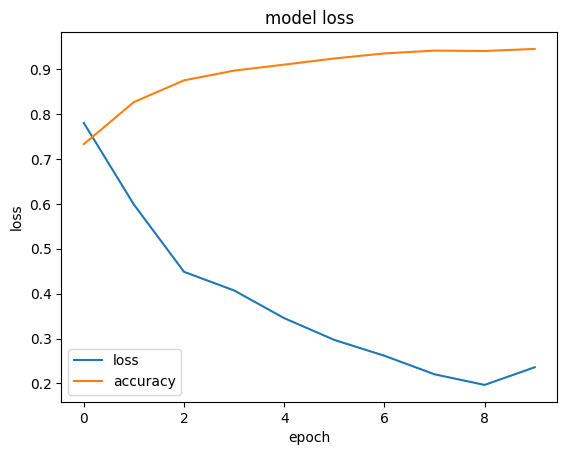

In [49]:
# Plotting Training and Validation Loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss', 'accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

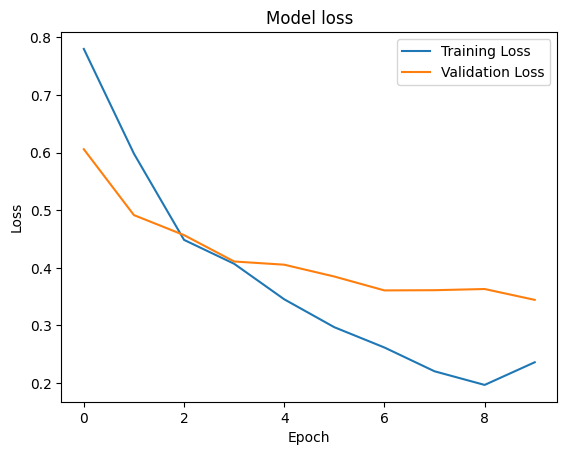

In [50]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [51]:
model = Sequential()
model.add(Dense(100, input_dim=X_vec_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Training and testing the model
history = model.fit(X_vec_train.toarray(), y_train, validation_data=(X_vec_test, y_test) ,epochs=50, batch_size=16)

y_pred = model.predict(X_vec_test.toarray())
print(accuracy_score(y_test, y_pred > 0.5))

Epoch 1/50
150/150 [==============================] - 1s 4ms/step - loss: 1.0448 - accuracy: 0.6208 - val_loss: 0.5965 - val_accuracy: 0.8383
Epoch 2/50
150/150 [==============================] - 0s 3ms/step - loss: 0.7348 - accuracy: 0.7079 - val_loss: 0.5663 - val_accuracy: 0.8433
Epoch 3/50
150/150 [==============================] - 0s 3ms/step - loss: 0.7531 - accuracy: 0.7421 - val_loss: 0.5414 - val_accuracy: 0.8567
Epoch 4/50
150/150 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.7937 - val_loss: 0.5103 - val_accuracy: 0.8650
Epoch 5/50
150/150 [==============================] - 0s 3ms/step - loss: 0.5920 - accuracy: 0.7967 - val_loss: 0.4848 - val_accuracy: 0.8700
Epoch 6/50
150/150 [==============================] - 0s 3ms/step - loss: 0.5656 - accuracy: 0.8183 - val_loss: 0.4613 - val_accuracy: 0.8783
Epoch 7/50
150/150 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.8413 - val_loss: 0.4333 - val_accuracy: 0.8817
Epoch 

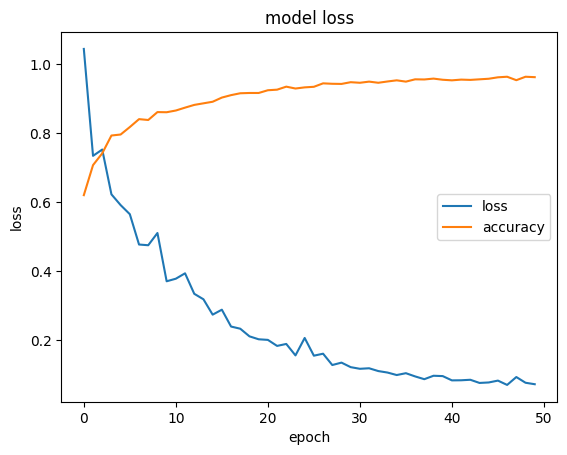

In [52]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='right')
plt.show()

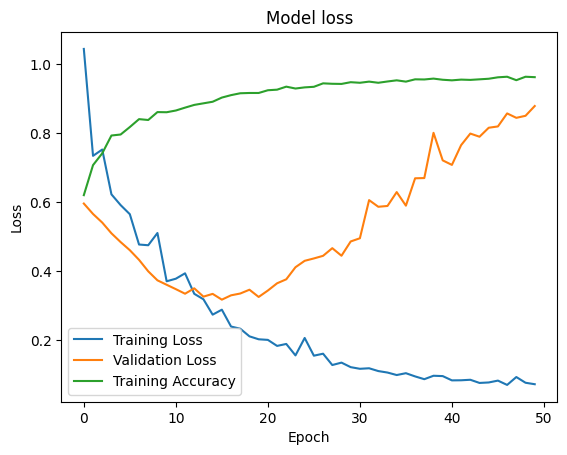

In [54]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In deze 2 Modellen, zie je dat in het eerste model er voor maar 10 epochs getraint is, en de accuracy rond de 94.8% is. In het tweede model, is het getraind voor 50 epochs. Je ziet hier dat de accuracy omhoog gaat naar 97.1% procent. 

Maar als je kijkt naar de plots, dan zie je dat er spraken is van overfitting, de loss op de validatie gaat omhoog, terwijl de training loss omlaag blijft gaan.

Wel raar dat de accuracy alsnog omhoog gaat na 10 epochs, terwijl er vanaf dat punt spraken is van overfitting.